# Tuning PLSR models and testing them against external datasets

## Setting up

In [1]:
# setting up
# imports
import pyreadr
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# calculate the mean of the pearson coefficients of multiple variables
def pair_pearsonr(x, y, axis=0): # this will allow us to take the pearson coefficient across two variables
    mx = np.mean(x, axis=axis, keepdims=True)
    my = np.mean(y, axis=axis, keepdims=True)
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym, axis=axis)
    r_den = np.sqrt((xm*xm).sum(axis=axis) * (ym*ym).sum(axis=axis))
    r = r_num / r_den
    return r

# plotting setup
# Use LaTeX for graphs' text
plt.rc('text', usetex=True)
# Use the serif font
plt.rc('font', family='serif')

In [ ]:
# import data, access pandas df via key "None"
X_Govaere = pyreadr.read_r("datasets/X_Govaere.rds")[None]
X_Hoang = pyreadr.read_r("datasets/X_Hoang.rds")[None]
X_Pantano = pyreadr.read_r("datasets/X_Pantano.rds")[None]

# actual, clinical results
Y_Govaere = pyreadr.read_r("datasets/Y_Govaere.rds")[None]
Y_Hoang = pyreadr.read_r("datasets/Y_Hoang.rds")[None]
Y_Pantano = pyreadr.read_r("datasets/Y_Pantano.rds")[None]

# viper metric, predicted results
Y_viper_Govaere = pyreadr.read_r("datasets/viper_X_Govaere.rds")[None]
Y_viper_Hoang = pyreadr.read_r("datasets/viper_X_Hoang.rds")[None]
Y_viper_Pantano = pyreadr.read_r("datasets/viper_X_Pantano.rds")[None]

all_results = pd.read_csv("datasets/PLSR_pearson_coefficients.csv")

In [155]:
# setup tuning procedure
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)
num_lvs = range(2, 11)

# select our training dataset
# TODO: CHANGE THE FOLLOWING LINES
training_dataset = "Pantano"
X = X_Pantano
Y = Y_Pantano

test1 = "Govaere"
test2 = "Hoang"

X_test1 = X_Govaere
X_test2 = X_Hoang
Y_test1 = Y_Govaere
Y_test2 = Y_Hoang

unique, freq = np.unique(Y.iloc[:,0], return_counts=True)
print(f"Unique NAS scores and their corresponding frequency:\n{[f'{(i,j)}' for i, j in zip(unique, freq)]}")
unique, freq = np.unique(Y.iloc[:,1], return_counts=True)
print(f"Unique Fibrosis scores and their corresponding frequency:\n{[f'{(i,j)}' for i, j in zip(unique, freq)]}")


Unique NAS scores and their corresponding frequency:
['(0.0, 32)', '(1.0, 12)', '(2.0, 9)', '(3.0, 11)', '(4.0, 13)', '(5.0, 18)', '(6.0, 12)', '(7.0, 9)']
Unique Fibrosis scores and their corresponding frequency:
['(0.0, 57)', '(1.0, 25)', '(2.0, 25)', '(3.0, 5)', '(4.0, 4)']


## Perform cross validation to find ideal number of latent variables

In [156]:
pearson_coeff_lvs = [] # containing tuples (num_lv, avg pearson coeff)

for latent_var in num_lvs:
    
    pearson_coeff = []

    # index into fibrosis column only because we need the correct dim for finding indices, and want to have as equal of splits as possible
    for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[1]])):

        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        Y_train = Y.iloc[train_index]
        Y_test = Y.iloc[test_index]

        model = PLSRegression(n_components=latent_var, scale=False)
        model.fit(X_train, Y_train)
        Y_test_hat = model.predict(X_test)

        # take the mean in order to be able to generalize the behavior on both phenotypes
        pearson_coeff.append(np.mean(pair_pearsonr(Y_test.values, Y_test_hat)))
    
    # evaluate the hyperparameter based on the average pearson coeff across all 10 folds
    pearson_coeff_lvs.append((latent_var, sum(pearson_coeff)/len(pearson_coeff)))

# print the result of the hyperparameter optimization
print(f'From 10-fold cross validation on training dataset {training_dataset}, {max(pearson_coeff_lvs, key=lambda x: x[1])[0]} latent variables achieves an average Pearson coeff of {max(pearson_coeff_lvs, key=lambda x: x[1])[1]}.')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


KeyboardInterrupt: 

In [121]:
# save the model so we can run it again
# this time, store the pearson's coeff for training and validation sets

best_lv = max(pearson_coeff_lvs, key=lambda x: x[1])[0]

latent_var = best_lv # our best performing hyperparameter
train_pearson_coeff = []
test_pearson_coeff = []

for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[1]])):
    
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]

    model = PLSRegression(n_components=latent_var, scale=False)
    model.fit(X_train, Y_train)
    
    Y_train_hat = model.predict(X_train) 
    train_pearson_coeff.append(np.mean(pair_pearsonr(Y_train.values, Y_train_hat)))
    
    Y_test_hat = model.predict(X_test) 
    test_pearson_coeff.append(np.mean(pair_pearsonr(Y_test.values, Y_test_hat)))
    
    filename = f"models/{training_dataset}_PLSR_fold_{i}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    
    print(f"Model for Fold {i} saved as {filename}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Model for Fold 0 saved as models/Pantano_PLSR_fold_0.pkl
Model for Fold 1 saved as models/Pantano_PLSR_fold_1.pkl
Model for Fold 2 saved as models/Pantano_PLSR_fold_2.pkl
Model for Fold 3 saved as models/Pantano_PLSR_fold_3.pkl
Model for Fold 4 saved as models/Pantano_PLSR_fold_4.pkl
Model for Fold 5 saved as models/Pantano_PLSR_fold_5.pkl
Model for Fold 6 saved as models/Pantano_PLSR_fold_6.pkl
Model for Fold 7 saved as models/Pantano_PLSR_fold_7.pkl
Model for Fold 8 saved as models/Pantano_PLSR_fold_8.pkl
Model for Fold 9 saved as models/Pantano_PLSR_fold_9.pkl


In [157]:
# load all models
loaded_models = []
for i in range(0, 10):
    filename = f"models/{training_dataset}_PLSR_fold_{i}.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
        loaded_models.append(model)
    print(f"Loaded model {i} from {filename}")

Loaded model 0 from models/Pantano_PLSR_fold_0.pkl
Loaded model 1 from models/Pantano_PLSR_fold_1.pkl
Loaded model 2 from models/Pantano_PLSR_fold_2.pkl
Loaded model 3 from models/Pantano_PLSR_fold_3.pkl
Loaded model 4 from models/Pantano_PLSR_fold_4.pkl
Loaded model 5 from models/Pantano_PLSR_fold_5.pkl
Loaded model 6 from models/Pantano_PLSR_fold_6.pkl
Loaded model 7 from models/Pantano_PLSR_fold_7.pkl
Loaded model 8 from models/Pantano_PLSR_fold_8.pkl
Loaded model 9 from models/Pantano_PLSR_fold_9.pkl


## Test with the best model on external and shuffled datasets

## Trying to recreate the all_coeff dataframe

# Hide the following

In [9]:
# running the model to create the total predicted scores
# run on the other two external test sets and the shuffled training dataset
# TODO: CHANGE THE FOLLOWING 6 LINES
X_test1 = X_Hoang
X_test2 = X_Pantano
Y_test1 = Y_Hoang
Y_test2 = Y_Pantano
test1 = "Hoang"
test2 = "Pantano"

train_pearson_coeff = []
validation_pearson_coeff = []
test1_pearson_coeff = []
test2_pearson_coeff = []
shuffled_pearson_coeff = []

for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[1]])):

    X_train = X.iloc[train_index]
    X_val = X.iloc[test_index]
    Y_train = Y.iloc[train_index]
    Y_val = Y.iloc[test_index]

    # model = loaded_models[i]
    model = PLSRegression(n_components=latent_var, scale=False)
    model.fit(X_train, Y_train)
    
    Y_train_hat = model.predict(X_train)
    train_pearson_coeff.append(np.mean(pair_pearsonr(Y_train.values, Y_train_hat)))
    
    Y_val_hat = model.predict(X_val)
    validation_pearson_coeff.append(np.mean(pair_pearsonr(Y_val.values, Y_val_hat)))
    
    Y_pred = model.predict(X_test1)
    test1_pearson_coeff.append(np.mean(pair_pearsonr(Y_test1.values, Y_pred)))

    Y_pred = model.predict(X_test2)
    test2_pearson_coeff.append(np.mean(pair_pearsonr(Y_test2.values, Y_pred)))

    Y_pred = model.predict(X_shuffled)
    shuffled_pearson_coeff.append(np.mean(pair_pearsonr(Y.values, Y_pred)))

    model = PLSRegression(n_components=latent_var, scale=False)
    model.fit(X_train, Y_train)

# Show the following

In [158]:
# creating a better all_coeff dataframe
# TODO: CHANGE THE FOLLOWING 6 LINES
# test1 = "Govaere"
# test2 = "Pantano"

# X_test1 = X_Govaere
# X_test2 = X_Pantano
# Y_test1 = Y_Govaere
# Y_test2 = Y_Pantano
X_shuffled = X.apply(lambda col: np.random.permutation(col.values), axis=0)
X_shuffled.index = X.index # ensure the gene names are maintained

results = [] # initialize list of all results

for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[1]])):

    # split data
    X_train = X.iloc[train_index]
    X_val = X.iloc[test_index]
    Y_train = Y.iloc[train_index]
    Y_val = Y.iloc[test_index]

    partitions = [[X_train, X_val, X_test1, X_test2, X_shuffled], [Y_train, Y_val, Y_test1, Y_test2, Y], ["Train", "Validation", test1, test2, "Shuffled"]]

    print(f'Evaluating fold {i}')
    model = loaded_models[i]

    for j in range(len(partitions[0])):
        
        Y_hat = model.predict(partitions[0][j])
        corr_nas, _ = pearsonr(partitions[1][j].values[:,0], Y_hat[:,0]) # NAS correlation
        corr_fib, _ = pearsonr(partitions[1][j].values[:,1], Y_hat[:,1]) # fibrosis correlation
        corr_mean = np.mean(pair_pearsonr(partitions[1][j].values, Y_hat)) # mean correlation
        
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "Fibrosis", 
            "Pearson_Coefficient": corr_fib
        })
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "NAS",
            "Pearson_Coefficient": corr_nas
        })
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "Combined",
            "Pearson_Coefficient": corr_mean
        })

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Evaluating fold 0
Evaluating fold 1
Evaluating fold 2
Evaluating fold 3
Evaluating fold 4
Evaluating fold 5
Evaluating fold 6
Evaluating fold 7
Evaluating fold 8
Evaluating fold 9


In [163]:
p = pd.DataFrame(results)
# results_df[(results_df["Phenotype"] == "NAS") & (results_df["Partition"] == "Pantano")]
# results_df

In [168]:
test = pd.concat([g, h, p])

In [170]:
# save
test.to_csv("datasets/PLSR_pearson_coefficients.csv", index=False)

## Plot with Mann-Whitney test

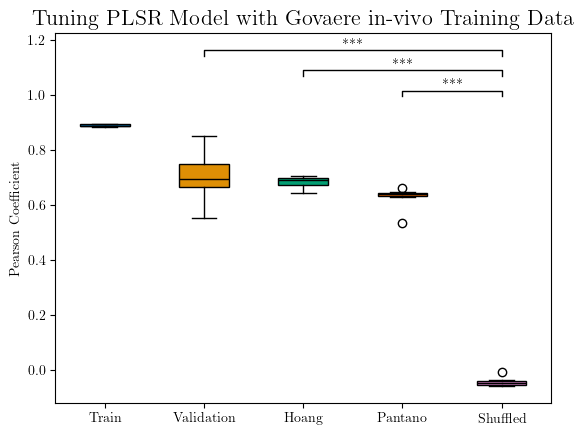

In [87]:
significant_combinations = []

combinations = [(x, 4) for x in [1, 2, 3]]
for combo in combinations:
    data1 = all_pearsons_coeff.iloc[:,combo[0]]
    data2 = all_pearsons_coeff.iloc[:,combo[1]]
    
    # calculate significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([combo, p])

# create a set of axes
ax = plt.axes()
# create a boxplot on the axes
bp = ax.boxplot(all_pearsons_coeff, patch_artist=True)
# graph title
ax.set_title(f"Tuning PLSR Model with {training_dataset} in-vivo Training Data", fontsize=16)
# label y-axis
ax.set_ylabel("Pearson Coefficient")

xticklabels = all_pearsons_coeff.columns.tolist()
ax.set_xticklabels(xticklabels)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('colorblind')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    # add one because the df indexing is 0 indexed, but plot is 1 indexed
    x1 = significant_combination[0][0] + 1 
    x2 = significant_combination[0][1] + 1
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

plt.savefig(f'graphs/PLSR_tuning_with_{training_dataset}.png', dpi=200)
plt.show()

In [75]:
significant_combinations

[[(1, 4), 0.00018267179110955002],
 [(2, 4), 0.00018267179110955002],
 [(3, 4), 0.00018267179110955002]]